# Welcome!
This is a notebook detailing my analysis of some data about motor theft in New Zealand over 6 months.
The records contain information about the vehicle, including its unique ID, type, make, manufacture year, color the location of the incident, the day it was added to the database.

I figured it was an appropriate phenomenon to study, considering the imminent announcement of GTA VI.

The dataset is kindly provided by the wonderful people at [Maven Analytics](mavenanalytics.io), it's acquired from the New Zealand police enforcement.

## Goals:
### Which vehicle types were stolen the most? 
- I don't know what to expect, it's a safe bet to rule vehicle types like mobile machines, and SPVs. I also expect sport cars to be stolen the least. Stealing a Kia is nothing like stealing a Ferrari.
### Have carjackings increased or decreased recently?
- Analyzing the changes and trends of the phenomenon.
### What day of the week are vehicles most often and least often stolen?
- I'm quite curious about this one! If you stole a car, what day would you choose to do it?
### Is the model year a factor?
- I expect prized cars from the 80s and earlier to be prime targets, highly valuable (particularly Japanese cars) without as much security as say, a 2023 Mercedes.
### Which regions had the most carjackings?
- I have no idea what the New Zealand provinces are, but a little filled map action will sort us well.




## Let's start by importing all the libraries we'll need:


In [126]:
# pandas
import pandas as pd

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# setting the visualization size for the whole notebook at once

plt.rcParams["figure.figsize"]=(15,8)

# seaborn, might need it
import seaborn as sns

#setting that shows seaborn visualizations instead of matplotlib's
sns.set()
sns.set_palette("tab10")
# setting which plot style to use
sns.set_style('darkgrid')

#magic function that stores all the plots in the notebook
%matplotlib inline

# this will stop some warnings from appearing, they're making my notebook look ugly
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

## Data Import and Preprocessing

### Next, we'll import our CSV files and perform some import pre-processing to save memory and time:
- First, we import the carjackings dataframe itself using **read_csv()**, set the date parser to true with specified date format, and downcast to smaller integer data types when possible, these preprocessing steps will save us both time and performance.


In [127]:
# little variable to help make the code more readable
veh_cols=["vehicle_id","vehicle_type","make_id","model_year","color","date_stolen","location_id"]

thefts = pd.read_csv("E:/projects/nz-motor-theft-py-analysis/stolen_vehicles.csv",
            usecols=veh_cols, # this will pass only the specified columns
            header=0, # setting the first row as the header
            parse_dates= ["date_stolen"], # allows pandas to directly make the date column a datetime64 type
            date_format= "%m/%d/%y", # helps pandas get the correct date format
            dtype={"vehicle_id": "Int16","make_id":"Int16","location_id":"Int16","model_year":"str"}, #notice the capital letter in the "Int"s, more on that later, also made the model_year a string since it's a categorical value
            keep_default_na=True #keeps the NA values, so we'll be able to get rid of them later
)
thefts.sample(5)

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id
2737,2738,Hatchback,587,2005,Silver,2021-12-22,102
3732,3733,Trailer,514,2009,Green,2022-03-14,115
728,729,Stationwagon,580,2001,Silver,2022-02-14,102
3169,3170,Saloon,619,2006,Black,2022-03-30,102
2732,2733,Saloon,512,2006,Grey,2021-11-21,103


Notice how the data type is "Int16" rather than "int16", this is called the Nullable Integer datatype, it allows the use of normal integers as well as null values. We used them to save ourselves having to downcast *after* dropping the missing values.

There's a lot of missing values here, and unfortunately we can't really do anything to fill them, so we'll have to get rid of them, but we'll save that for the cleaning stage.

- For now, we'll import the second CSV file, the make details table.

In [128]:
makes = pd.read_csv('E:/projects/nz-motor-theft-py-analysis/make_details.csv',
            index_col = "make_id",
            header=0, 
            dtype={"make_id":"Int16"},
            keep_default_na=True  
)
makes.sample(5)

,make_name,make_type
make_id,,
526,Crusader,Standard
541,Forza,Standard
630,Veteran,Standard
592,Peugeot,Standard
535,Domett,Standard


What a pretty dataframe. We'll join it to the first table soon, using **merge()** - pandas' version of the SQL join, I love SQL, so I feel right at home.


- Now to import the location data:

In [129]:
location_cols=["location_id","region","population"] # columns to imported, there's only one country after all
locations = pd.read_csv('E:/projects/nz-motor-theft-py-analysis/locations.csv',
            index_col = "location_id",
            usecols=location_cols,
            header=0, 
            dtype={"location_id":"int8"},
            keep_default_na=True
  )
locations

,region,population
location_id,,
101,Northland,"201,500"
102,Auckland,"1,695,200"
103,Waikato,"513,800"
104,Bay of Plenty,"347,700"
105,Gisborne,"52,100"
106,Hawke's Bay,"182,700"
107,Taranaki,"127,300"
108,Manawatū-Whanganui,"258,200"
109,Wellington,"543,500"


## Now that we have our data ready, it's time for cleaning.

- First, we'll check the stolen vehicles table:

In [130]:
thefts.shape

(4553, 7)

6 columns and 4527 rows, including the ones with missing data.

In [131]:
thefts.isna().sum() #first method will tell us if the value is missing or not


vehicle_id       0
vehicle_type    26
make_id         15
model_year      15
color           15
date_stolen      0
location_id      0
dtype: int64

Plenty of missing values. As mentioned before, we can't really fill them with anything, so we'll just get rid of any rows missing data using **dropna()**
Thankfully, it's only 26 rows. Negligible against the remaining 4520 (and header)

In [132]:
thefts = thefts.dropna(axis = 0, how = "any") #this will delete *any* rows that are missing values
thefts.isna().sum()

vehicle_id      0
vehicle_type    0
make_id         0
model_year      0
color           0
date_stolen     0
location_id     0
dtype: int64

I noticed that the list of vehicle types column is quite granular and could do with a little touch up. We'll use **contains()** nested in **where()** to replace any rows.


In [133]:
thefts["vehicle_type"].unique()

array(['Trailer', 'Boat Trailer', 'Roadbike', 'Moped', 'Trailer - Heavy',
       'Caravan', 'Hatchback', 'Saloon', 'Stationwagon', 'Tractor',
       'Trail Bike', 'Light Van', 'All Terrain Vehicle', 'Utility',
       'Other Truck', 'Sports Car', 'Flat Deck Truck', 'Light Bus',
       'Mobile Home - Light', 'Convertible', 'Heavy Van',
       'Special Purpose Vehicle', 'Articulated Truck',
       'Cab and Chassis Only', 'Mobile Machine'], dtype=object)

The way I see it:
- A trailer isn't that different to a boat trailer. <br>
- Vans should be a single category as well. <br>
- Some truck categories have too small a value, so we'll include those in a big truck category.
- Cab & Chassis Only trucks are simply trucks without the truck.<br>
- I will also change "Mobile Home - Light" into "Mobile Home" because there's only one type.<br>

I apologize, it's quite an ugly snippet of code, and yes, I did try to use the **regex** library, but it doesn't support Dataframes and Series. So, I ended up making this:

In [134]:
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Trailer') == False), other="Trailer")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Truck') == False), other="Truck")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Van') == False), other="Van")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Bus') == False), other="Bus")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'] != "Mobile Home - Light"), other="Mobile Home")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'] != "Cab and Chassis Only"), other="Truck")
thefts['vehicle_type'].unique()

array(['Trailer', 'Roadbike', 'Moped', 'Caravan', 'Hatchback', 'Saloon',
       'Stationwagon', 'Tractor', 'Trail Bike', 'Van',
       'All Terrain Vehicle', 'Utility', 'Truck', 'Sports Car', 'Bus',
       'Mobile Home', 'Convertible', 'Special Purpose Vehicle',
       'Mobile Machine'], dtype=object)

It replaces any rows with the mention of a trailer with simply "trailer", van with "vans" and so on.
I spent over an hour trying to avoid that spaghetti but alas.

### We'll add a column for both days and months for some of our anaylses for later.

In [135]:
thefts["month"]= thefts["date_stolen"].dt.month
thefts["day"]= thefts["date_stolen"].dt.day_of_week
thefts.sample(5)


,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day
166,167,Caravan,525,1972,Red,2022-03-16,104,3,2
3824,3825,Hatchback,633,2017,Silver,2021-12-22,102,12,2
1858,1859,Hatchback,580,2006,Blue,2021-11-23,102,11,1
1920,1921,Stationwagon,559,2008,Black,2021-12-25,102,12,5
3040,3041,Trailer,623,2007,Silver,2022-03-27,102,3,6


### Next, we'll check the makes table for any missing values, it's a lookup table, so I'm hoping nothing is missing.
Let's look at the shape:


In [136]:
makes.shape

(138, 2)

Let's check if any of these 138 rows are missing any data:


In [137]:
makes.isna().sum()

make_name    0
make_type    0
dtype: int64

None! What a relief.
Now, for the location table, it's likely the same, as it's a lookup table as well.

In [138]:
locations.shape

(16, 2)

In [139]:
locations.isna().sum()

region        0
population    0
dtype: int64

Success! There is no missing data in our lookup tables!

# Joining the Data tables:
For this, we'll use **merge()**, and NOT **join()** and keys like make_id and location_id. We'll do two tables at a time to keep the code more readable.

First, we'll join the theft and make tables, using the make_id column, which is common to both tables.

In [140]:
thefts_w_makes = thefts.merge(makes,"left",left_on=thefts["make_id"],right_index=True)
thefts_w_makes.head()

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day,make_name,make_type
0,1,Trailer,623,2021,Silver,2021-11-05,102,11,4,Trailer,Standard
1,2,Trailer,623,2021,Silver,2021-12-13,105,12,0,Trailer,Standard
2,3,Trailer,623,2021,Silver,2022-02-13,102,2,6,Trailer,Standard
3,4,Trailer,623,2021,Silver,2021-11-13,106,11,5,Trailer,Standard
4,5,Trailer,623,2018,Silver,2022-01-10,102,1,0,Trailer,Standard


Next, we'll join the location data, for the complete package:

In [141]:
thefts_full = thefts_w_makes.merge(locations,"left",left_on=thefts_w_makes["location_id"],right_index=True)
thefts_full.sample(5)

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day,make_name,make_type,region,population
869,870,Roadbike,611,2019,White,2022-02-16,109,2,2,Suzuki,Standard,Wellington,"543,500"
2909,2910,Saloon,576,2007,White,2022-04-04,103,4,0,Mazda,Standard,Waikato,"513,800"
3620,3621,Saloon,619,2010,White,2022-02-21,114,2,0,Toyota,Standard,Canterbury,"655,000"
2483,2484,Hatchback,550,1997,Green,2021-12-11,109,12,5,Honda,Standard,Wellington,"543,500"
1882,1883,Saloon,576,1994,Green,2022-03-03,107,3,3,Mazda,Standard,Taranaki,"127,300"


Voilà! Now, we have the complete table, just like we would in SQL. We have the date of the theft, when and where it was committed, and which type of vehicle was stolen, etc. we are ready to aggregate!

# Aggregating and plotting the data:

In this step, we will:
- Aggregate the data by time, location, and make etc. to answer our questions.
- Use different visualizations to hopefully complete a sound and insightful analysis into this phenomenon.

### Which vehicle types were stolen the most? 
To answer this question, it's a simple process of summing the thefts by make type, using **groupby()** and **agg()**.
I also used **query()** to filter out types that have been stolen less than 5 times, and used the **plot()** method to do the, well, plotting.

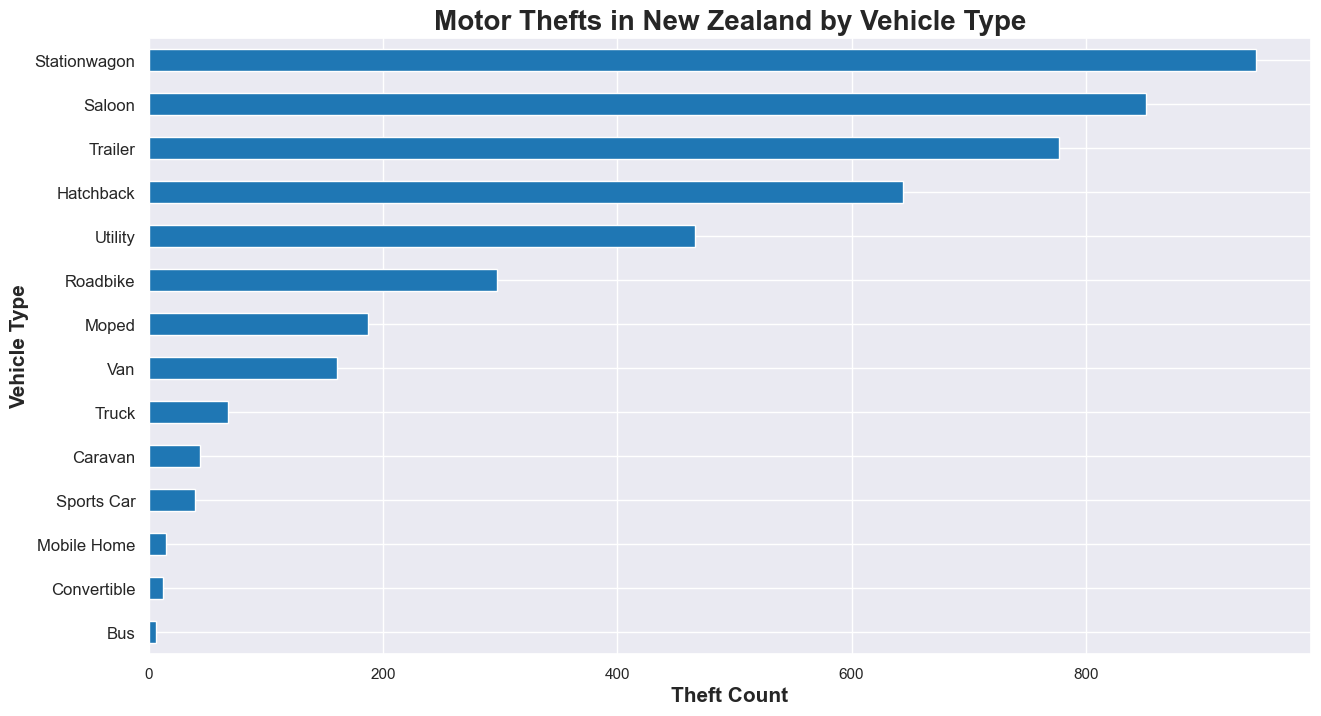

In [142]:
(thefts_full
.groupby('vehicle_type')
.agg(theft_count=('vehicle_id','count'))# each record is a theft, so counting them is counting the thefts
.query("theft_count > 5") # Skipping vehicle types that have less than 5 thefts
.sort_values("theft_count", ascending=True) # sorting the bars to make them easier to read
.rename(columns={"theft_count":"Thefts"}) # renaming the aggregated column to something neat
.plot(kind="barh", # setting the viz type to horizontal bar chart
legend=False))
plt.xlabel("Theft Count", fontweight="bold", fontsize=15), #formatting the label on the x axis
plt.ylabel("Vehicle Type", fontweight="bold",fontsize=15) #formatting the label on the y axis
plt.yticks(fontweight=500, fontsize=12) # formatting the ticks on the y axis
plt.title("Motor Thefts in New Zealand by Vehicle Type", fontweight="bold", fontsize=20); #formatting the title

When it comes to cars, we notice that saloons and station wagons reign supreme. Sport cars are often conspicuous and come with extra security features, as they're usually high end, making them harder to steal. Wagons are neat, the new V90 from Volvo looks amazing.

Trailers also seem to be stolen quite often, I'm still trying to wrap my head around how that would work, does the thief just bring a semi truck or tractor and takes it away? That doesn't seem too difficult now that I think about it.

### Has the number of carjacking increased recently?
Mostly the same code as last time, except this time we'll filter the values using **.loc()** only to January 2022, aggregate using the date column, and make a line chart.

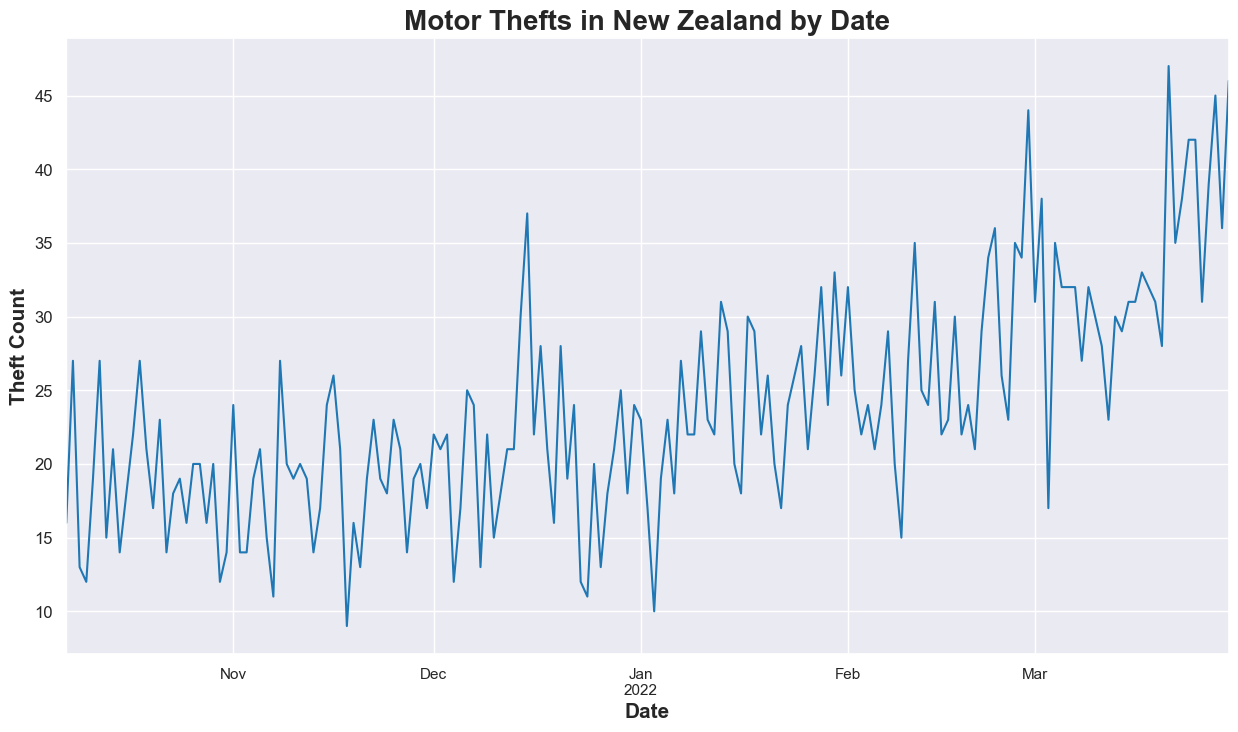

In [143]:
(thefts_full.loc[(thefts_full["date_stolen"] < "2022-03-31")]
.groupby('date_stolen')
.agg(theft_count=('vehicle_id','count'))
.rename(columns={"theft_count":"Thefts"})
.plot(kind="line", 
legend=False))
plt.title("Motor Thefts in New Zealand by Date", fontweight="bold", fontsize=20)
plt.xlabel("Date", fontweight="bold", fontsize=15),
plt.ylabel("Theft Count", fontweight="bold",fontsize=15)
plt.yticks(fontweight=500, fontsize=12);

We notice an increase after 2022, possibly due to the lift of COVID-19 regulations.

### What day of the week are vehicles most often and least often stolen?
A simple bar chart will do for this one.
We'll use an array of day numbers, and a list of day names, and run them in the xticks function. I initially tried to do this with a dictionary, but that surprisingly didn't work!

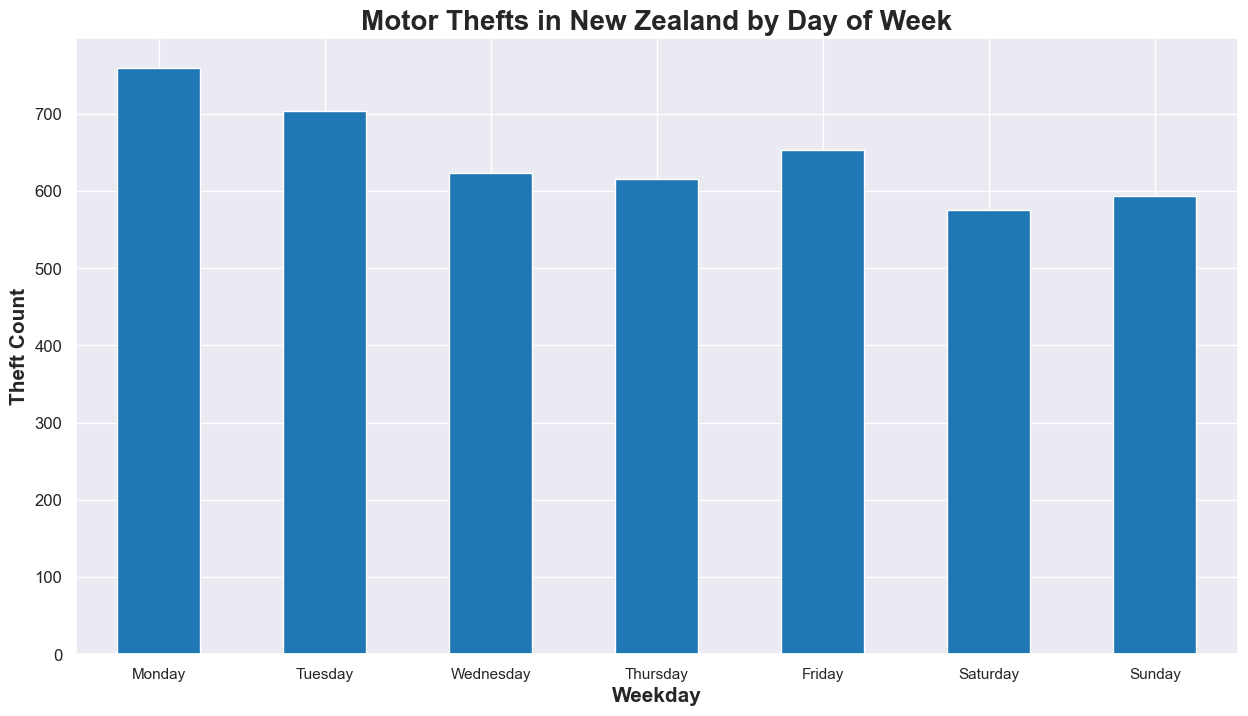

In [144]:
day_of_week = [0,1,2,3,4,5,6] #setting the ticks for the xticks function to make the code easier to read
day_name = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"] # setting the tick labels to make the code easier to read
(thefts_full
.groupby("day")
.agg(theft_count=('vehicle_id','count'))
.rename(columns={"theft_count":"Thefts"})
.plot(kind="bar", 
legend=False))
plt.xticks(ticks= day_of_week, labels = day_name, rotation=0, fontweight= 500) 
plt.xlabel("Weekday", fontweight="bold", fontsize=15),
plt.ylabel("Theft Count", fontweight="bold",fontsize=15)
plt.yticks(fontweight=500, fontsize=12);
plt.title("Motor Thefts in New Zealand by Day of Week", fontweight="bold", fontsize=20);

Early days of the week seem to have more thefts than the rest of the week, but not by much. There's a slight increase on Fridays but not as much as Mondays and Tuesdays.
Getting your car stolen on Monday seems like a terrific way to start your week.

### Is the model year a factor?
I wanted to use a line chart for this one, for a little variety, but it is not a time series analysis! Almost made a huge mistake there. We'll sort by highest value to prevent it from looking like a time series analysis as well.

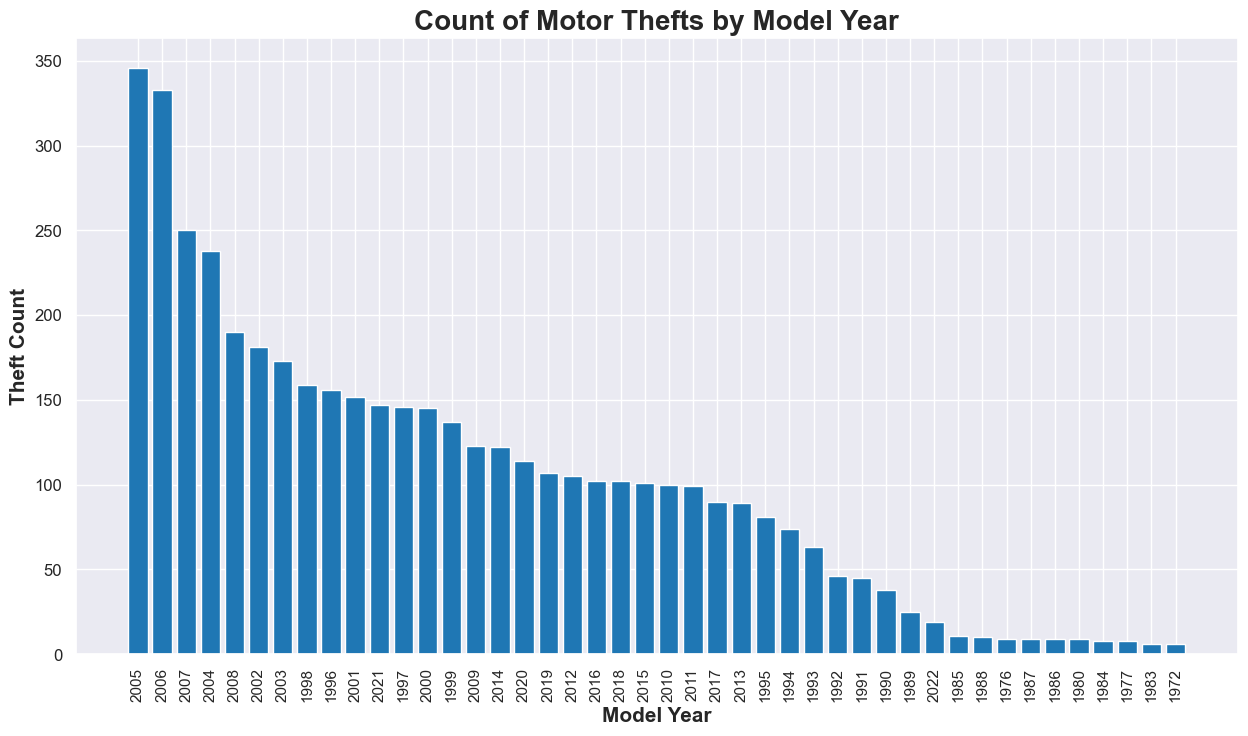

In [145]:
m_year = (thefts_full
.groupby('model_year')
.agg(theft_count=('vehicle_id','count'))
.query("theft_count > 5")
.rename(columns={"theft_count":"Thefts"})
.sort_values("Thefts", ascending=False)
)
m_year = m_year.reset_index() #resetting the index into a new one so we can use the model_year column
plt.bar(x=m_year['model_year'],
        height=m_year['Thefts'],)
plt.title("Count of Motor Thefts by Model Year", fontweight="bold", fontsize=20)
plt.xticks(rotation=90)
plt.xlabel("Model Year", fontweight="bold", fontsize=15),
plt.ylabel("Theft Count", fontweight="bold",fontsize=15)
plt.yticks(fontweight=500, fontsize=12);

It seems that cars made in the mid 2000s are the most popular targets. They're in the sweet spot between old and modern - not too old that they're falling apart, nor too new that they're difficult to steal. And the further back we go, there's very small thefts, as classic and vintage cars are too conspicuous to be stolen (most of the time). So there goes my theory. <br>
And no mob bosses would drive a 2005 car! Except if said mob boss has exquisite taste and drives an Audi A8L D3 with the W12 (yes it's one of my dream cars)

### Which regions had the most carjackings?
I want a filled map for this one. First order of business is to get an SHP file with the New Zealand provinces.

Okay a filled map is a tad too advanced for me. I'll just do the good old horizontal bar chart. I even tried Bard and the code didn't work, it was an unbelievable pain in the neck, it was a good learning experience all the same.

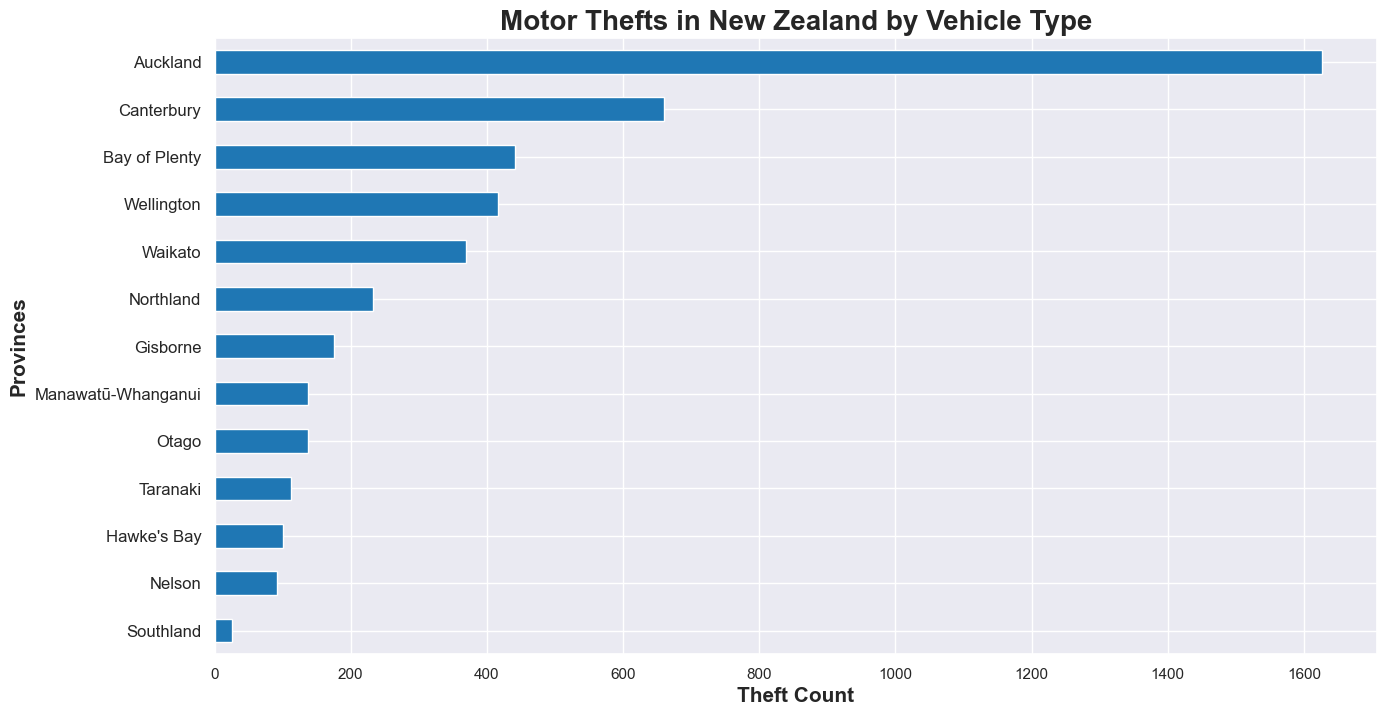

In [146]:
(thefts_full
.groupby('region')
.agg(theft_count=('vehicle_id','count')) 
.sort_values("theft_count", ascending=True)
.rename(columns={"theft_count":"Thefts"})
.plot(kind="barh",
legend=False))
plt.title("Motor Thefts in New Zealand by Vehicle Type", fontweight="bold", fontsize=20)
plt.xlabel("Theft Count", fontweight="bold", fontsize=15),
plt.ylabel("Provinces", fontweight="bold",fontsize=15)
plt.yticks(fontweight=500, fontsize=12);

In [147]:
#converting the population column into numerical values so we can look at the top 5 most populated provinces
#the column is populated by numbers seperated at thousands with commas, so we'll have to get rid of those
#locations['population']=(locations['population'].str.split(',') #splitting the values at the commas
#.str.join('') #rejoining the values without any thousands seperator
#.astype('int')) #converting the values into integers
locations.sort_values("population", ascending=False).head()

,region,population
location_id,,
114,Canterbury,"655,000"
110,Tasman,"58,700"
109,Wellington,"543,500"
111,Nelson,"54,500"
105,Gisborne,"52,100"


Wow! Auckland's car theft count is colossal compared to the rest, over double the count of the runner-up, Canterbury. Auckland and Canterbury are the two most populated provinces in the country, with the former at 1.7 million people, and the latter at 655K, so it makes sense that they have such a high count of motor theft.

Bay of Plenty on the other hand, has an abnormally high rate of motor theft, despite being just slightly above half Canterbury's population.

# Insights

- Station Wagons, Saloons, and trailers are the three most stolen vehicle types. I guess if you're going to steal a car, might as well get yourself something practical, or just stick the trailer into the tractor and drive off!
- This phenomenon seems to be rising over the last few months, possibly due to economic problems following the COVID lockdown.
- The early days of the week suffer from higher counts of motor theft, though, only by a small margin. 

- Vehicles from the mid 2000s are the most stolen in these months, likely because they're in the sweet spot, not too old, not too new. I don't know about NZ, but cars of this period in the US are extremely boring and plain looking, very inconspicuous, so they're easier to steal, I think.

- The top two provinces when it comes to motor theft are also the two most populated in the country. Bay of Plenty, however, has an abnormally high rate despite only having slightly more than half the population of Canterbury, the second most populated province.

# Recap
Finally done! It's been quite difficult, trying to figure out the filled map was very difficult, and despite using Bard I couldn't adapt its code to suit my needs. On a brighter note, it's so satisfying to clean the data and merge the tables, and I really enjoyed learning about the patterns of motor theft in the country, I don't know how to feel about car thieves placing practicality over flash in the cars they steal, but I suppose inconspicuousness comes first.